In [1]:
import numpy as np
import copy
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
import torch
import torch.nn as nn
import dynamic_nn_pt as dynn

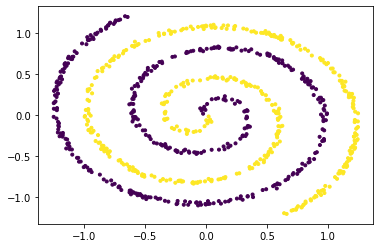

In [32]:
def twospirals(n_points, noise=.5):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

x, y = twospirals(400)
x, y = x/10, y.reshape(-1)
xx, yy = torch.FloatTensor(x), torch.FloatTensor(y.reshape(-1,1))

x1 = xx[:,0]
x2 = xx[:,1]

%matplotlib inline
plt.scatter(x1, x2, c=y, marker='.')
plt.show()

In [41]:
dynet = dynn.Dynamic_Network(2, 1, final_activation=nn.Sigmoid(),
                             num_stat=5, num_std=250, decay_rate_std=0.03)
criterion = nn.BCELoss()

In [91]:
### hyperparameters
num_add_neuron = 6
num_decay_steps = 1000
threshold_max = 0.1
threshold_min = 0.001
learning_rate = 0.01

train_step_min = 700
train_step_max = 7000

In [43]:
dynet.tree.add_to_remove_ratio = 2.

### when to stop training functionality

In [44]:
def update_coeff(num_iter=5, lr=0.9):
    if len(loss_list)<10: return np.array([0]), np.array([0]), float(coeff.data[0])
    
    _t = torch.tensor(loss_list)
    _t = (_t - _t[-1])/(_t[0]-_t.min()) ## normalize to make first point at 1 and last at 0 
    _t = torch.clamp(_t, -1.1, 1.1)
    _x = torch.linspace(0, 1, steps=len(_t))
    
    for _ in range(num_iter):
        coeff_opt.zero_grad()
        _y = torch.exp(coeff*_x)*(1.00001-_x)*coeff1 + coeff2

        _loss = ((_y - _t)**2).mean()
        if loss>10.:
            print("Loss too high")
            continue
        _loss.backward()
        coeff_opt.step()

        coeff.data = torch.clamp(coeff.data, -20., 20.)
        coeff1.data = torch.clamp(coeff1.data, 0.7, 2.)
        coeff2.data = torch.clamp(coeff2.data, -0.2,0.1)
        
    _y = torch.exp(coeff*_x)*(1-_x)*coeff1 + coeff2

    return _x.numpy(), _t.numpy(), _y.data.numpy()

## Train Network dynamically

In [137]:
dynet.add_neurons(num_add_neuron)

In [138]:
dynet.print_network()

2
├────┐
│    ├────┐
│    │    7
│    ├────┘
│    8
│    ├────┐
│    │    5
│    ├────┘
├────┘
│
1


In [139]:
optimizer = torch.optim.Adam(dynet.parameters(), lr=learning_rate)

coeff = torch.zeros(1, requires_grad=True)
coeff1 = torch.zeros(1, requires_grad=True)
coeff2 = torch.zeros(1, requires_grad=True)
coeff_opt = torch.optim.Adam([coeff, coeff1, coeff2], lr=1)
loss_list = []

### Training Step

In [140]:
%matplotlib tk
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

for epoch in range(train_step_max):

    dynet.decay_neuron_step()
    dynet.tree.std_loss = 0.    

    yout = dynet(xx)
    loss = criterion(yout, yy) + dynet.tree.decay_rate_std*dynet.tree.std_loss
    
    if epoch>100:
        loss_list.append(float(loss))
    
    optimizer.zero_grad()
    loss.backward(retain_graph=False)
    optimizer.step()
    
    if epoch%100 == 0:
        _x, _t, _y = update_coeff(50)
        _c = float(coeff.data[0])

        print(f'Epoch: {epoch}, Loss:{float(loss)}, coeff:{_c}')
        ax.clear()

        out = (yout.data.numpy()>0.5).astype(int)
        ax.scatter(x1, x2, c=out, marker='.')
        
        ax2.clear()
        if len(_x)>0:
            ax2.plot(_x, _y, c='m')
            ax2.plot(_x, _t, c='c')

        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")
        
        if _c < -5 and epoch>train_step_min: break

plt.close()

Epoch: 0, Loss:0.02598545141518116, coeff:0.0


Epoch: 100, Loss:0.0159765612334013, coeff:0.0


Epoch: 200, Loss:0.010833397507667542, coeff:-0.8762457966804504


Epoch: 300, Loss:0.008342616260051727, coeff:-0.9519959092140198


Epoch: 400, Loss:0.00649285688996315, coeff:-0.8546138405799866


Epoch: 500, Loss:0.005450391210615635, coeff:-1.079595923423767


Epoch: 600, Loss:0.005079065449535847, coeff:-1.5878986120224


Epoch: 700, Loss:0.004863889422267675, coeff:-2.109468698501587


Epoch: 800, Loss:0.00468222051858902, coeff:-2.6280815601348877


Epoch: 900, Loss:0.004518423695117235, coeff:-3.139305591583252


Epoch: 1000, Loss:0.004401523619890213, coeff:-3.649965763092041


Epoch: 1100, Loss:0.004273869097232819, coeff:-4.154661178588867


Epoch: 1200, Loss:0.004156508948653936, coeff:-4.635037899017334


Epoch: 1300, Loss:0.004038018640130758, coeff:-5.082884311676025




In [141]:
dynet.print_network_debug()

H:0[2,1]σ[t:0.9999999999999862, s:0.9363014101982117
|     S:1[2,1]
|     R:1[8|8]
|     |     H:2[2,8]σ[t:0.9999999999999862, s:0.7113313674926758
|     |     |     S:3[2,8]
|     |     |     R:3[7|7]
|     |     |     |     H:4[2,7]σ[t:0.0, s:0.0
|     |     |     |     |     S:5[2,7]
|     |     |     |     H:4[7,8]σ[t:0.0, s:0.0
|     |     |     |     |     S:5[7,8]
|     |     H:2[8,1]σ[t:0.8328802083131567, s:0.8298932313919067
|     |     |     S:3[8,1]
|     |     |     R:3[5|5]
|     |     |     |     H:4[8,5]σ[t:0.0, s:0.0
|     |     |     |     |     S:5[8,5]
|     |     |     |     H:4[5,1]σ[t:0.0, s:0.0
|     |     |     |     |     S:5[5,1]


## Compute Significance

In [142]:
dynet.start_computing_significance()

for epoch in range(1):
    yout = dynet(xx)
    yout.backward(gradient=torch.ones_like(yout))
    optimizer.zero_grad()

dynet.finish_computing_significance()

#### start removing less significant neurons

In [143]:
dynet.identify_removable_neurons(num=None,
                                 threshold_min = threshold_min,
                                 threshold_max = threshold_max)

(tensor(0.0002),
 tensor([4.2641e-03, 3.2435e-03, 1.8441e-03, 6.7345e-04, 5.0326e-05, 1.4391e-02,
         3.6117e-03, 3.4015e-03, 6.8758e-03, 2.6314e-03, 1.0675e-02, 2.4682e-04,
         2.8916e-03, 6.1959e-03, 4.9174e-03, 2.0402e-03, 7.2742e-04, 6.1484e-05,
         5.3925e-04, 7.6770e-04]))

In [144]:
dynet.decay_neuron_start(decay_steps=num_decay_steps)

2

## Actual Removing

In [145]:
%matplotlib tk
fig = plt.figure()
ax = fig.add_subplot(111)

for epoch in range(num_decay_steps+5):
    dynet.decay_neuron_step()
    dynet.tree.std_loss = 0.

    yout = dynet(xx)
    loss = criterion(yout, yy) + dynet.tree.decay_rate_std*dynet.tree.std_loss
    
    optimizer.zero_grad()
    loss.backward(retain_graph=False)
    optimizer.step()
    
    if epoch%100 == 0:
        print(f'Epoch: {epoch}, Loss:{float(loss)}')
        ax.clear()

        out = (yout.data.numpy()>0.5).astype(int)
        ax.scatter(x1, x2, c=out, marker='.')
        
        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")
        
plt.close()

Epoch: 0, Loss:0.004040445201098919


Epoch: 100, Loss:0.0039098202250897884


Epoch: 200, Loss:0.0037969283293932676


Epoch: 300, Loss:0.0036858064122498035


Epoch: 400, Loss:0.0035793199203908443


Epoch: 500, Loss:0.0034802958834916353


Epoch: 600, Loss:0.003385687479749322


Epoch: 700, Loss:0.0032875114120543003


Epoch: 800, Loss:0.0031815487891435623


Epoch: 900, Loss:0.0030762176029384136


Epoch: 1000, Loss:0.003219381207600236




In [101]:
dynet.print_network()

2
├────┐
│    ├────┐
│    │    3
│    ├────┘
│    5
│    ├────┐
│    │    3
│    ├────┘
├────┘
│
1


#### compute del_neuron statstics after removing neurons

In [102]:
dynet.compute_del_neurons()

## Maintain Structure of Network

In [103]:
dynet.maintain_network()

In [104]:
len(dynet.tree.DYNAMIC_LIST)

3

## Repeat from start

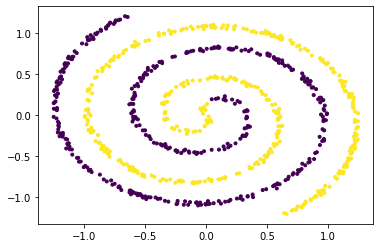

In [121]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x1, x2, c=out, marker='.')

In [120]:
dynet.print_network()

2
├────┐
│    ├────┐
│    │    8
│    ├────┘
│    6
│    ├────┐
│    │    3
│    ├────┘
├────┘
│
1
